In [8]:
%matplotlib inline

In [7]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# PID Controller
### Proportional-integral-derivative controller

## Introduction
A proportional–integral–derivative controller (also known as a three-term controller, though this is not always accurate – as we will see at the end of the Components section) is a feedback-based control loop mechanism commonly used to manage machines and processes that require continuous control and automatic adjustments. It is typically employed in industrial control systems where constant modulation is necessary without human intervention. Recently, it has also been used in everyday consumer technology. The PID controller automatically compares the target value (setpoint or $\text{SP}$) with the actual value of the system (process variable or $\text{PV}$). The difference between these two values is called the error value, denoted as $e(t)$.

The three correcting terms sum up to form the manipulated variable ($\text{MV}$). Let’s denote the controller output as $𝑢(𝑡)$ Thus, the final form of the PID controller algorithm can be expressed as:

$$ u(t) = MV(t) = K_p e(t) + K_i \int_{0}^{t} e(\tau) \text{d}\tau + K_\text{d} \frac{\text{d}e(t)}{\text{d}t} $$

It is important to note that:

$K_p$ (proportional gain), $K_i$ (integral gain), $K_d$ (derivative gain) are tuning parameters (more on that in the Tuning section)

$e(t) = \text{SP} - \text{PV}(t)$ is the error

$t$ is the time or instantaneous time (the present),

$\tau$ is the variable of integration (takes on values from time $0$ to the present $t$).

## Example use cases
Let’s start with three examples that we’ll explore to help us understand what the actual operation of this algorithm looks like in practice.
### Two-wheeled self-balancing robots
A common example is a two-wheeled robot that balances itself. When the robot tilts forward or backward, the PID controller adjusts the wheel speed to maintain balance. This is achieved by continuously measuring the tilt angle and adjusting the motor power to restore balance quickly and smoothly, preventing the robot from tipping over.
### Vehicle's cruise control system
Another common example is the cruise control system in a car. For instance, when a car is climbing a hill, its speed will drop if the engine’s power output remains constant. The PID controller automatically adjusts the engine power to bring the car back to the desired speed efficiently, with minimal delay and overshoot.
### Temperature control system
Another example is temperature control in an industrial oven. If the oven temperature drops below the setpoint due to sudden heat loss (for example, when the door is opened), the PID controller increases the heating element’s power output to return the temperature to the desired level efficiently, minimizing overshoot and ensuring stable operation.

## Components
The PID controller algorithm consists of three main parts. Each letter in PID corresponds to one of them.

It is important to note that there are situations in which one or two parts can be omitted. We will see examples of that further in this section.

We are going to dive into each of them separately by partialy implementing the **Temperature control system** example. (Let's get some water boiling)

However, before diving into the individual components, it would be helpful to have a way to visualize the results of each term. That’s why we need a plotting function.

In [127]:
def plot_terms(time, process_values, setpoint, label, title, color='blue'):
    plt.figure(figsize=(10, 6))
    plt.plot(time, process_values, label=label, color=color)
    plt.axhline(setpoint, color='r', linestyle='--', label='Setpoint')
    plt.xlabel('Time (s)')
    plt.ylabel('Process Variable')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

### P - Proportional
The proportional term generates an output that directly relates to the current error value. This response is controlled by multiplying the error by a proportional gain constant $K_p$.

The proportional term is given by

$$ P_{out} = K_p e(t) $$

When $K_p$ is high, even a small change in error causes a large output adjustment, which can make the system unstable if set too high. On the other hand, a low $K_p$ leads to a weak output response even for significant errors, making the controller less sensitive and slower to react. If $K_p$ is too low, the controller might not correct disturbances effectively.

To begin with, let's implement the function that calculates the proportional term.

In [128]:
# Kp stands for the proportional gain
# error = e(t) which is the current error
def proportional_term(Kp, error):
    # applying the gain and calculating the term
    p_out = Kp * error

    # returns the calculated proportional output
    return p_out

Let's begin by initializing some values.

In [137]:
# the proportional term output is proportional to the error
Kp = 1.0

# the desired temperature inside the oven
setpoint = 100

# the starting temperature inside the oven
process_variable = 20

# time interval for precise calculations
dt = 0.1

# 10 seconds time interval
time = np.arange(0, 10, dt)

# list to store the results
process_values = []

In [138]:
for t in time:
    error = setpoint - process_variable
    P_out = proportional_term(Kp, error)
    output = P_out  # Only proportional term
    process_variable += output * dt - 0.1 * (process_variable - 20) * dt  # Heat loss
    process_values.append(process_variable)

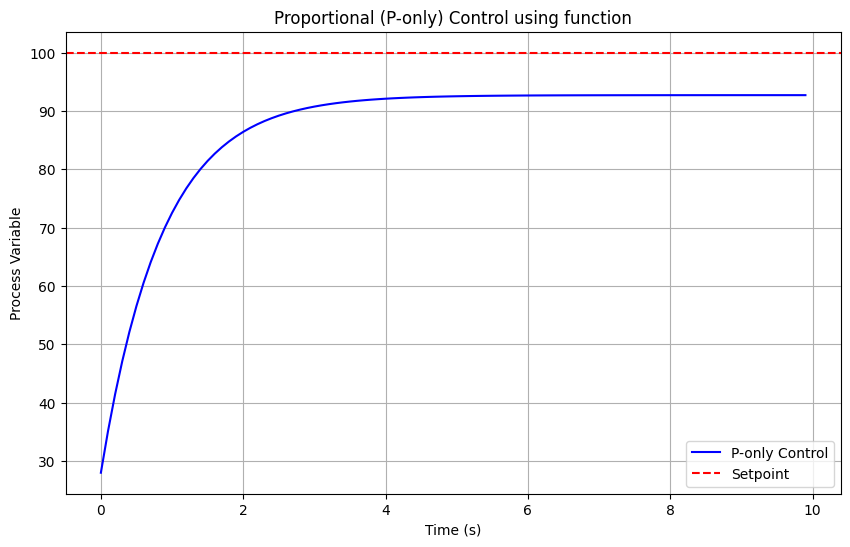

In [140]:
plot_terms(time, process_values, setpoint, label='P-only Control', title='Proportional (P-only) Control using function', color='blue')

### I - Integral
The integral term accounts for both how large the error is and how long it lasts. It sums up the error over time, capturing the total accumulated deviation that should have been corrected before. This accumulated error is then multiplied by the integral gain ($K_i$) and added to the controller’s output.

The integral term is given by

$$ I_{out} = K_i \int_{0}^{t} e(\tau) \text{d}\tau $$

The integral action helps the process reach the target value faster and removes the steady-state error that a proportional controller alone cannot fix. However, since it reacts to past accumulated errors, it may cause the process to overshoot the desired setpoint.

To begin with, let's implement the function that calculates the integral term.

In [77]:
# Ki stands for the integral gain
# integral is the accumulated integral
# dt is the time step
# error = e(t) which is the current error
def integral_term(Ki, integral, error, dt):
    # updating the integral value
    integral = integral + error * dt

    # appllying the gain and calculating the term
    i_out = Ki * integral

    # returns the calculated integral output and the updated integral
    return i_out, integral

Let's begin by initializing some values.

In [133]:
# relatively small value to avoid accumulation and instability
Ki = 0.1

# the desired temperature inside the oven
setpoint = 100

# the starting temperature inside the oven
process_variable = 20

# always start the integral part from zero because there are not any accumulated errors in the beginning
integral = 0

# small time interval for precise calculations
dt = 0.1

# 10 seconds time interval
time = np.arange(0, 10, dt)

# list to store the results
process_values = []

In [134]:
for t in time:
    error = setpoint - process_variable
    I_out, integral = integral_term(Ki, integral, error, dt)
    output = I_out  # Only integral term
    process_variable += output * dt - 0.1 * (process_variable - 20) * dt  # Heat loss
    process_values.append(process_variable)

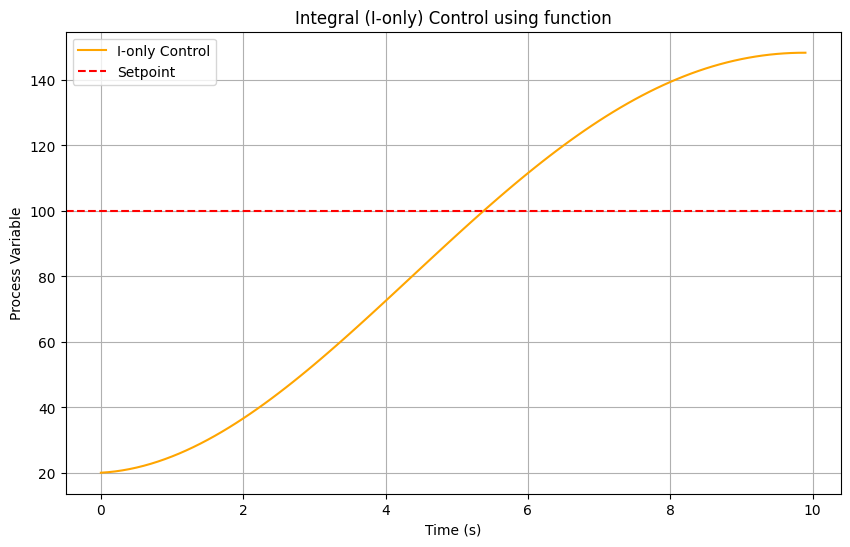

In [135]:
plot_terms(time, process_values, setpoint, label='I-only Control', title='Integral (I-only) Control using function', color='orange')

### D - Derivative
The derivative term is found by measuring how fast the error changes over time and then multiplying this rate by the derivative gain, $K_d$. This gain determines the influence of the derivative term on the overall control output.

$$ D_{out} = K_\text{d} \frac{\text{d}e(t)}{\text{d}t} $$

Derivative control helps predict the system’s future behavior, which improves how quickly the system stabilizes and increases its stability. Since an ideal derivative can’t be implemented directly, practical PID controllers apply a low-pass filter to the derivative term to reduce noise and limit high-frequency effects.

Despite these benefits, derivative action is seldom used in practice - estimated to be included in only about 25% of controllers—because it can have unpredictable effects on system stability in real-world conditions.

To begin with, let's implement the function that calculates the derivative term.

In [145]:
# Kd stand for the derivative gain
# previous_error is the error from the previous step
# dt is the time step
# error = e(t) which is the current error
def derivative_term(Kd, error, previous_error, dt):
    # calculate the rate of change of the error (how fast the error is changing over time)
    derivative = (error - previous_error) / dt
    
    # appllying the gain and calculating the term
    d_out = Kd * derivative
    
    # returns the calculated derivative output
    return d_out

Let's begin by initializing some values.

In [146]:
# relatively small value to avoid instability due to quick reaction to changes
Kd = 0.5

# the desired temperature inside the oven
setpoint = 100

# the starting temperature inside the oven
process_variable = 20

# always start the previous error at zero because there are not any errors in the beginning
previous_error = 0

# small time interval for precise calculations
dt = 0.1

# 10 seconds time interval
time = np.arange(0, 10, dt)

# list to store the results
process_values = []

In [147]:
for t in time:
    error = setpoint - process_variable
    D_out = derivative_term(Kd, error, previous_error, dt)
    output = D_out  # Only derivative term
    process_variable += output * dt - 0.1 * (process_variable - 20) * dt  # Heat loss
    process_values.append(process_variable)
    previous_error = error

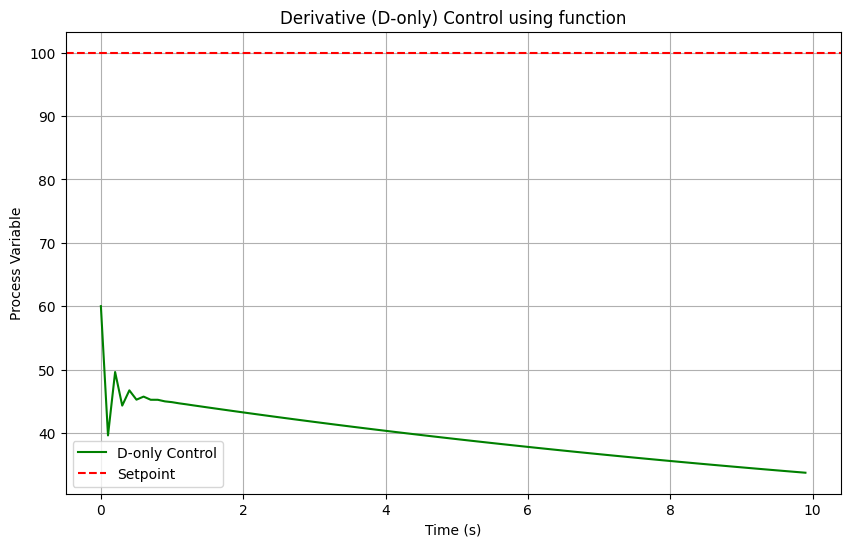

In [149]:
plot_terms(time, process_values, setpoint, label='D-only Control', title='Derivative (D-only) Control using function', color='green')

### How do they work together
The PID controller automatically applies corrections to bring the $\text{PV}$ to the same value as the $\text{SP}$. The Proportional (P) component responds to the current error value by producing an output that is directly proportional to the magnitude of the error. At the same time, the Integral (I) component considers the cumulative sum of past errors to eliminate residual steady-state errors that persist over time, thus removing any remaining discrepancies. Finally, the Derivative (D) component predicts future errors by assessing the rate of change of the error, which helps reduce overshoot and enhance system stability, especially during sudden changes.

After we combine the three separate parts we get the final formula

$$ K_p e(t) + K_i \int_{0}^{t} e(\tau) \text{d}\tau + K_\text{d} \frac{\text{d}e(t)}{\text{d}t} $$

In [108]:
def pid_controller(Kp, Ki, Kd, setpoint, process_variable, integral, previous_error, dt):
    """
    Calculate the full PID control output.
    """
    error = setpoint - process_variable

    P_out = proportional_term(Kp, error)
    I_out, integral = integral_term(Ki, integral, error, dt)
    D_out = derivative_term(Kd, error, previous_error, dt)

    output = P_out + I_out + D_out

    return output, integral, error  # Return updated integral and error (as previous_error)

In [109]:
# Parameters
Kp, Ki, Kd = 1.0, 0.1, 0.05
setpoint = 100
process_variable = 20
integral = 0
previous_error = 0
dt = 0.1
time = np.arange(0, 10, dt)

# Lists to store results
pv_list = []
p_list = []
i_list = []
d_list = []
output_list = []

In [110]:
for t in time:
    error = setpoint - process_variable

    # Individual terms
    P_out = proportional_term(Kp, error)
    I_out, integral = integral_term(Ki, integral, error, dt)
    D_out = derivative_term(Kd, error, previous_error, dt)

    # PID output
    output, integral, previous_error = pid_controller(
        Kp, Ki, Kd, setpoint, process_variable, integral, previous_error, dt
    )

    # Simulate process: simple model of heating
    process_variable += output * dt - 0.1 * (process_variable - 20) * dt

    # Store values
    pv_list.append(process_variable)
    p_list.append(P_out)
    i_list.append(I_out)
    d_list.append(D_out)
    output_list.append(output)

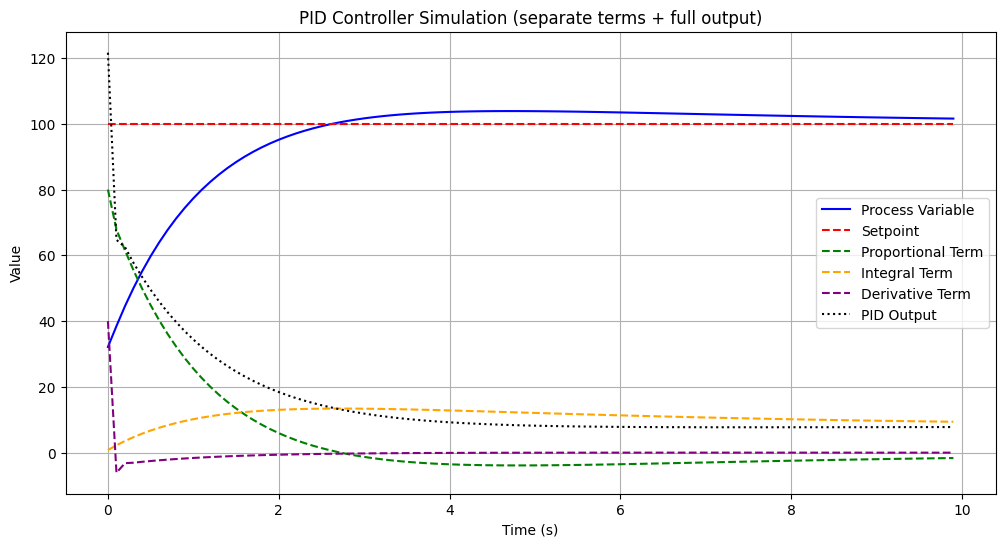

In [111]:
plt.figure(figsize=(12, 6))
plt.plot(time, pv_list, label="Process Variable", color="blue")
plt.plot(time, [setpoint]*len(time), "r--", label="Setpoint")
plt.plot(time, p_list, "--", label="Proportional Term", color="green")
plt.plot(time, i_list, "--", label="Integral Term", color="orange")
plt.plot(time, d_list, "--", label="Derivative Term", color="purple")
plt.plot(time, output_list, label="PID Output", color="black", linestyle=":")
plt.xlabel("Time (s)")
plt.ylabel("Value")
plt.legend()
plt.title("PID Controller Simulation (separate terms + full output)")
plt.grid()
plt.show()

### Selective use of control terms
Although the PID controller algorithm consists of three parts, there are situations in which one or two of them are sufficient to provide proper control. This can be achieved by setting the unused values to zero. In such cases, the algorithm is referred to as a PI, PD, P, or I controller. The integral part is often necessary for the system to reach the desired output. For example, the PID algorithm is frequently used in its PI form in cases where differentiation would be sensitive to measurement noise.

As mentioned in the Derivative subsection, the letter D is often omitted from the algorithm. Let's see an example for a PI controller

Good example for PI usage is a **Lighting Control in a Room with a Lamp**

In a lighting control system for a room, the goal is to maintain constant brightness, compensating for changes in natural light. These changes are usually smooth and gradual — for example, during sunset. In this case, PI control (proportional and integral) is sufficient to ensure stable regulation without a steady-state error. Adding a derivative term in this situation is rarely necessary and can even introduce unnecessary noise into the system, since there are no abrupt changes that would require predicting future behavior.

Let’s see a quick demonstration of how the PI controller works in this example scenario and then discuss what happens.

### What happens if there is a missing component?
We already saw an example where the derivative part can be omitted. However, it is not always the best idea to skip the Derivative term. What would happen if it is required and not present? What problems could occur?

Good example for PI that needs its Derivative term is a **Position Control of a Robotic Manipulator Arm**

In control systems for robotic manipulators performing precise movements, the derivative (D) component is extremely important. The arm's position must be controlled with high accuracy, and the movements are often fast and abrupt. Without the D component, the controller would only react to the current error and the accumulated integral error, which can lead to oscillations or excessive delay in reaching the target position. The derivative term anticipates the future behavior of the error, reducing oscillations and improving the stability and accuracy of the motion.

Let’s see a quick demonstration of how the PI controller would work in this example scenario. After that, we’ll observe how it performs when the Derivative term is also included. Finally, we’ll explain the observed differences and discuss why incorporating the Derivative term can be important in some cases.

## Tuning
### Why is it important?
Some explainations

## Advantages and disadvantages
### Advantages
Explanaitions
### Disadvantages
Explanaitions

## Alternatives
Examples

## In conclusion
Some final words...

## Dictionary
**Set Point:** Set Point is a value that is usually set by the user. In the example of cruise control, it is the desired speed that the vehicle should maintain.

**Process Value:** Process Value is the value that is processed by the PID controller. In the cruise control example, this is the current (actual) speed of the vehicle.

**Output:** The output of the PID controller is calculated by summing the proportional, integral, and derivative terms. Their effect on the output depends on their respective gain coefficients. In a cruise control system, for example, the output of the PID controller is the control signal to the throttle valve.

**Error:** Error is the value used by the PID controller to determine how to adjust the output so that the process value approaches the set point.

**Gain:** Gain is used as a multiplication factor for the three PID terms – Proportional, Integral, and Derivative. By adjusting it, the user can control the influence of the PID controller on the entire system.

## Sources
[Proportional–integral–derivative controller - Wikipedia](https://en.wikipedia.org/wiki/Proportional%E2%80%93integral%E2%80%93derivative_controller)

[PID explained](https://pidexplained.com/pid-controller-explained/)

[How to tune PID](https://pidexplained.com/how-to-tune-a-pid-controller/)

[Basic implementation](https://medium.com/@aleksej.gudkov/python-pid-controller-example-a-complete-guide-5f35589eec86)